In [2]:
import pandas as pd
import json
import urllib
import os
import random
from urllib.parse import quote
from IPython.display import Image
from datetime import datetime


In [3]:
paintings = pd.read_csv('data/wikidata_all_paintings.csv')
paintings = paintings.drop_duplicates(subset='item', keep='first')
food_keywords = pd.read_csv('data/food_related_words.csv')

display(paintings.head())
display(food_keywords)

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_19427/656354371.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  paintings = pd.read_csv('data/wikidata_all_paintings.csv')


,item,creation_date,display_country,type,school,image_url,depicts,origin_country,time_period
0,http://www.wikidata.org/entity/Q724861,1612-01-01T00:00:00Z,United States of America,portrait,NaN,http://commons.wikimedia.org/wiki/Special:File...,"book, man, skull, English people, White people...",NaN,NaN
1,http://www.wikidata.org/entity/Q727875,1538-01-01T00:00:00Z,Italy,mythological painting,Venetian school,http://commons.wikimedia.org/wiki/Special:File...,"dog, sky, twilight, earring, flower, nipple, t...",Republic of Venice,NaN
5,http://www.wikidata.org/entity/Q605863,1530-01-01T00:00:00Z,Italy,portrait,NaN,http://commons.wikimedia.org/wiki/Special:File...,"book, man, table, mandolin, lizard",NaN,NaN
6,http://www.wikidata.org/entity/Q607598,1445-01-01T00:00:00Z,Spain,religious art,Gothic painting,http://commons.wikimedia.org/wiki/Special:File...,"Mary, Andrew the Apostle, throne, angel, Chris...",NaN,NaN
7,http://www.wikidata.org/entity/Q607761,1793-01-01T00:00:00Z,NaN,genre art,Romanticism,http://commons.wikimedia.org/wiki/Special:File...,"death, horse, man, spear, bullfighting, stadiu...",NaN,NaN


,word,count,closest_food_term,food_similarity_score
0,fruit,925,fruit,1.000000
1,bread,242,bread,1.000000
2,tableware,140,cookware,0.623472
3,fish,132,seafood,0.570744
4,wine,127,wine,1.000000
...,...,...,...,...
96,manure,1,vegetable,0.583847
97,oats,1,dairy,0.515907
98,veal,1,dairy,0.568498
99,legume,1,vegetable,0.551566


In [4]:


# --- One-Hot Encoding Based on Closest Food Terms ---

# Step 1: Create a mapping from word to closest_food_term
word_to_food_term = food_keywords.set_index('word')['closest_food_term'].str.lower().to_dict()

# Step 2: Prepare the list of unique closest_food_terms for one-hot encoding
unique_food_terms = food_keywords['closest_food_term'].str.lower().unique()

# Step 3: Handle missing 'depicts' by replacing NaN with empty string
paintings['depicts'] = paintings['depicts'].fillna('')

# Step 4: Split the 'depicts' column into lists of words, lowercase, and strip whitespace
paintings['depicts_list'] = paintings['depicts'].str.lower().str.split(',').apply(lambda x: [word.strip() for word in x])

# Step 5: Explode the lists to create a row for each word
depicts_exploded = paintings.explode('depicts_list')

# Step 6: Map each word to its closest_food_term if it exists in the mapping
depicts_exploded['closest_food_term'] = depicts_exploded['depicts_list'].map(word_to_food_term)

# Step 7: Remove rows where there is no matching word in DataFrame B (i.e., closest_food_term is NaN)
matched_depicts = depicts_exploded.dropna(subset=['closest_food_term'])

# Step 8: Create one-hot encoded columns for the closest_food_terms
food_dummies = pd.get_dummies(matched_depicts['closest_food_term'])

# Step 9: Ensure that all unique_food_terms are represented as columns
food_dummies = food_dummies.reindex(columns=unique_food_terms, fill_value=0)

# Step 10: Aggregate the dummy columns back to the original DataFrame A's index
food_dummies_grouped = food_dummies.groupby(matched_depicts.index).max()

# Step 11: Join the one-hot encoded columns back to DataFrame A
paintings = paintings.join(food_dummies_grouped)

# Step 12: Fill any missing values in the one-hot encoded columns with 0
paintings[unique_food_terms] = paintings[unique_food_terms].fillna(0).astype(int)

# Step 13: Ensure all one-hot encoded columns are present in DataFrame A
for term in unique_food_terms:
    if term not in paintings.columns:
        paintings[term] = 0

# Optional Step: Drop the temporary 'depicts_list' column
paintings = paintings.drop(columns=['depicts_list'])

# Display the updated DataFrame A
print("Updated DataFrame A with One-Hot Encoded Closest Food Terms:")
display(paintings.head())

# If you want to save the updated DataFrame to a CSV file, uncomment the following line:
# df_A.to_csv('updated_dataframe_A_with_food_terms.csv', index=False)

Updated DataFrame A with One-Hot Encoded Closest Food Terms:


,item,creation_date,display_country,type,school,image_url,depicts,origin_country,time_period,fruit,...,seafood,wine,meal,cheese,meat,food,beverage,dairy,vegetable,dessert
0,http://www.wikidata.org/entity/Q724861,1612-01-01T00:00:00Z,United States of America,portrait,NaN,http://commons.wikimedia.org/wiki/Special:File...,"book, man, skull, English people, White people...",NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,http://www.wikidata.org/entity/Q727875,1538-01-01T00:00:00Z,Italy,mythological painting,Venetian school,http://commons.wikimedia.org/wiki/Special:File...,"dog, sky, twilight, earring, flower, nipple, t...",Republic of Venice,NaN,0,...,0,0,0,0,0,0,0,0,0,0
5,http://www.wikidata.org/entity/Q605863,1530-01-01T00:00:00Z,Italy,portrait,NaN,http://commons.wikimedia.org/wiki/Special:File...,"book, man, table, mandolin, lizard",NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
6,http://www.wikidata.org/entity/Q607598,1445-01-01T00:00:00Z,Spain,religious art,Gothic painting,http://commons.wikimedia.org/wiki/Special:File...,"Mary, Andrew the Apostle, throne, angel, Chris...",NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
7,http://www.wikidata.org/entity/Q607761,1793-01-01T00:00:00Z,NaN,genre art,Romanticism,http://commons.wikimedia.org/wiki/Special:File...,"death, horse, man, spear, bullfighting, stadiu...",NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Define the columns to sum (one-hot encoded food term columns)
columns_to_sum = unique_food_terms

# Sum each row for the specified columns and add a new column 'food_count'
paintings['food_count'] = paintings[columns_to_sum].sum(axis=1)

# Display the updated DataFrame
paintings = paintings.sort_values('food_count', ascending=False)

paintings.dropna(subset=['image_url'], inplace=True)


In [6]:
def get_image_path(url,path='img/img_512/'):
    parsed = urllib.parse.urlparse(url)
    # First decoding: %2520 -> %20
    first_decode = urllib.parse.unquote(parsed.path)
    # Second decoding: %20 -> space
    #second_decode = urllib.parse.unquote(first_decode)
    filename = os.path.basename(first_decode)
    # Replace spaces with underscores as per MediaWiki API requirements
    #filename = filename.replace(' ', '_')
    return path + filename

paintings['image_path'] = paintings['image_url'].apply(get_image_path)

In [7]:
# Export a list of images not present in the directory for rows that contain food
missing_image_paths = paintings[paintings['food_count'] > 0 & ~paintings['image_path'].apply(os.path.exists)]
display(missing_image_paths)


,item,creation_date,display_country,type,school,image_url,depicts,origin_country,time_period,fruit,...,meal,cheese,meat,food,beverage,dairy,vegetable,dessert,food_count,image_path
106733,http://www.wikidata.org/entity/Q27064304,1566-01-01T00:00:00Z,France,genre art,NaN,http://commons.wikimedia.org/wiki/Special:File...,"carrot, cherry, woman, fire, man, meat, vegeta...",NaN,NaN,0,...,0,0,1,0,0,1,1,1,5,img/img_512/Intérieur de cuisine - Joachim Beu...
536,http://www.wikidata.org/entity/Q776175,1565-01-01T00:00:00Z,United States of America,genre art,Northern Renaissance,http://commons.wikimedia.org/wiki/Special:File...,"sea, woman, sky, church building, summer, food...",NaN,NaN,0,...,1,0,1,1,1,0,1,0,5,img/img_512/Pieter Bruegel the Elder- The Harv...
9190,http://www.wikidata.org/entity/Q12900365,1868-01-01T00:00:00Z,Germany,genre art,NaN,http://commons.wikimedia.org/wiki/Special:File...,"wine, woman, book, child, bread, newspaper, bi...",NaN,NaN,0,...,1,1,0,0,0,0,0,0,5,img/img_512/The Luncheon (SM sg170).png
117282,http://www.wikidata.org/entity/Q27974915,1650-01-01T00:00:00Z,Russia,pronk still life,NaN,http://commons.wikimedia.org/wiki/Special:File...,"man, vegetable, house cat, table, Hound, game,...",NaN,NaN,1,...,0,0,0,0,0,1,1,0,4,img/img_512/Paul de Vos and Jacob Jordaens - C...
57660,http://www.wikidata.org/entity/Q20532659,1884-01-01T00:00:00Z,Denmark,still life,NaN,http://commons.wikimedia.org/wiki/Special:File...,"beer, cheese, table, chair, butter, pipe, lunch",NaN,NaN,0,...,1,1,0,0,1,0,0,1,4,"img/img_512/OA Hermansen, Et frokostbord, 1884..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125329,http://www.wikidata.org/entity/Q28031701,1649-01-01T00:00:00Z,NaN,still life,NaN,http://commons.wikimedia.org/wiki/Special:File...,"flower, fruit",NaN,NaN,1,...,0,0,0,0,0,0,0,0,1,img/img_512/Attributed to Mario Nuzzi (1603-73...
1246,http://www.wikidata.org/entity/Q3633844,1551-01-01T00:00:00Z,Sweden,inverted still-life,NaN,http://commons.wikimedia.org/wiki/Special:File...,"sausage, Flight into Egypt, butcher shop, mark...",NaN,NaN,0,...,0,0,0,0,0,0,0,1,1,img/img_512/Pieter Aertsen 005.jpg
244371,http://www.wikidata.org/entity/Q55428853,1610-01-01T00:00:00Z,Norway,still life,NaN,http://commons.wikimedia.org/wiki/Special:File...,"vase, fruit",NaN,NaN,1,...,0,0,0,0,0,0,0,0,1,"img/img_512/Ukjent kunstner, flamsk, Clara Pee..."
271680,http://www.wikidata.org/entity/Q61744340,1642-01-01T00:00:00Z,NaN,still life,NaN,http://commons.wikimedia.org/wiki/Special:File...,"oyster, tablecloth, lemon, berkemeyer, lobster...",NaN,NaN,0,...,0,0,0,0,0,0,0,0,1,img/img_512/Jan Davidsz. de Heem - Still-Life ...


In [8]:

# Save the list to a text file
missing_image_paths.to_csv('data/missing_image_paths.csv', index=False)

In [9]:
paintings_with_food = paintings[['item','image_path']].join(paintings[unique_food_terms])



# Remove image paths ending with 'tif'
paintings_with_food = paintings_with_food[~paintings_with_food['image_path'].str.endswith('.tif')]
# Filter out image paths that do not exist in the specified directory
paintings_with_food = paintings_with_food[paintings_with_food['image_path'].apply(lambda x: os.path.exists(x))]




# Display the updated DataFrame
display(paintings_with_food)

paintings_with_food.to_csv('data/paintings_with_food_nlp.csv', index=False)

,item,image_path,fruit,bread,cookware,seafood,wine,meal,cheese,meat,food,beverage,dairy,vegetable,dessert
106733,http://www.wikidata.org/entity/Q27064304,img/img_512/Intérieur de cuisine - Joachim Beu...,0,0,0,1,0,0,0,1,0,0,1,1,1
536,http://www.wikidata.org/entity/Q776175,img/img_512/Pieter Bruegel the Elder- The Harv...,0,0,0,0,0,1,0,1,1,1,0,1,0
9190,http://www.wikidata.org/entity/Q12900365,img/img_512/The Luncheon (SM sg170).png,0,1,0,1,1,1,1,0,0,0,0,0,0
117282,http://www.wikidata.org/entity/Q27974915,img/img_512/Paul de Vos and Jacob Jordaens - C...,1,0,0,1,0,0,0,0,0,0,1,1,0
57660,http://www.wikidata.org/entity/Q20532659,"img/img_512/OA Hermansen, Et frokostbord, 1884...",0,0,0,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229059,http://www.wikidata.org/entity/Q51243217,img/img_512/Ivan Žabota - mrs. Ležovičovej.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0
227362,http://www.wikidata.org/entity/Q51247485,"img/img_512/Alex Colville - Infantry, near Nij...",0,0,0,0,0,0,0,0,0,0,0,0,0
227128,http://www.wikidata.org/entity/Q51235353,img/img_512/Ivan Žabota - Marta Krásovej.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0
227922,http://www.wikidata.org/entity/Q51265369,img/img_512/Ivan Žabota - ženski portret.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
paintings_image_path = paintings_with_food[['image_path','item']]
paintings_image_path.to_csv('data/paintings_image_path.csv', index=False)

In [11]:
# Filter paintings that have at least one food-related term
paintings_subset = paintings_with_food[paintings_with_food[unique_food_terms].sum(axis=1) > 0]
paintings_subset

,item,image_path,fruit,bread,cookware,seafood,wine,meal,cheese,meat,food,beverage,dairy,vegetable,dessert
106733,http://www.wikidata.org/entity/Q27064304,img/img_512/Intérieur de cuisine - Joachim Beu...,0,0,0,1,0,0,0,1,0,0,1,1,1
536,http://www.wikidata.org/entity/Q776175,img/img_512/Pieter Bruegel the Elder- The Harv...,0,0,0,0,0,1,0,1,1,1,0,1,0
9190,http://www.wikidata.org/entity/Q12900365,img/img_512/The Luncheon (SM sg170).png,0,1,0,1,1,1,1,0,0,0,0,0,0
117282,http://www.wikidata.org/entity/Q27974915,img/img_512/Paul de Vos and Jacob Jordaens - C...,1,0,0,1,0,0,0,0,0,0,1,1,0
57660,http://www.wikidata.org/entity/Q20532659,"img/img_512/OA Hermansen, Et frokostbord, 1884...",0,0,0,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35265,http://www.wikidata.org/entity/Q19925488,img/img_512/Still Life with Fruit MET ap1982.1...,1,0,0,0,0,0,0,0,0,0,0,0,0
130091,http://www.wikidata.org/entity/Q28062078,img/img_512/Michiel Simons (1620-1673) - Still...,1,0,0,0,0,0,0,0,0,0,0,0,0
98710,http://www.wikidata.org/entity/Q26000816,img/img_512/Peter Paul Rubens - Sleeping Silen...,1,0,0,0,0,0,0,0,0,0,0,0,0
1246,http://www.wikidata.org/entity/Q3633844,img/img_512/Pieter Aertsen 005.jpg,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:

paintings_subset = paintings_subset.drop(columns='item')
#paintings_subset = paintings_subset.sample(1000, random_state=1)
paintings_subset = paintings_subset.reset_index(drop=True)
paintings_subset.to_csv('data/paintings_subset.csv', index=False)

In [13]:


# Define the label columns
label_columns = unique_food_terms

# Function to create predictions
def create_prediction(row):
    selected_labels = [label.capitalize() for label in label_columns if row[label] == 1]
    if selected_labels:
        return {
            "result": [
                {
                    "from_name": "labels",
                    "to_name": "image",
                    "type": "choices",
                    "value": {
                        "choices": selected_labels
                    }
                }
            ]
        }
    else:
        return {"result": []}

# Create the Label Studio JSON structure with predictions
label_studio_data = []
for _, row in paintings_with_food.iterrows():
    data_entry = {
        "data": {
            "image": '/data/local-files/?d='+row['image_path'] # Ensure the path is correct
        },
        "predictions": [create_prediction(row)]
    }
    label_studio_data.append(data_entry)

# Save to JSON file

# Get the current timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save to JSON file with timestamp in the filename
""" with open(f'label_studio_predictions_{timestamp}.json', 'w') as f:
    json.dump(label_studio_data, f, indent=4) """

" with open(f'label_studio_predictions_{timestamp}.json', 'w') as f:\n    json.dump(label_studio_data, f, indent=4) "

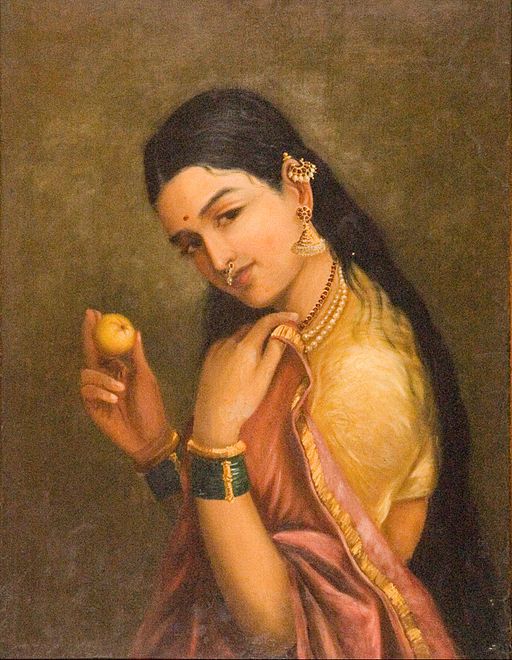

In [154]:


# Select a random image path from the DataFrame
random_image_path = random.choice(paintings_subset['image_path'].tolist())

# Display the image
display(Image(filename=random_image_path))

In [155]:
random_image_path

'img/img_512/Raja Ravi Varma - Woman Holding a Fruit - Google Art Project.jpg'